・ColaboratoryでPython、Notebookの操作のおさらい
・ColaboratoryでChainerを使うための設定
・Chainerで衣類の画像を分類してみよう

chainerを使うための設定

In [0]:
! pip freeze

absl-py==0.6.1
altair==2.2.2
astor==0.7.1
atomicwrites==1.2.1
attrs==18.2.0
beautifulsoup4==4.6.3
bleach==3.0.2
cachetools==3.0.0
certifi==2018.10.15
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
cymem==2.0.2
cytoolz==0.9.0.1
decorator==4.3.0
defusedxml==0.5.0
dill==0.2.8.2
entrypoints==0.2.3
future==0.16.0
gast==0.2.0
google-api-core==1.5.2
google-api-python-client==1.6.7
google-auth==1.4.2
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud-bigquery==1.1.0
google-cloud-core==0.28.1
google-cloud-language==1.0.2
google-cloud-storage==1.8.0
google-cloud-translate==1.3.1
google-colab==0.0.1a1
google-resumable-media==0.3.1
googleapis-common-protos==1.5.5
grpcio==1.15.0
h5py==2.8.0
httplib2==0.11.3
idna==2.6
ipykernel==4.6.1
ipython==5.5.0
ipython-genutils==0.2.0
Jinja2==2.10
joblib==0.13.0
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
Keras==2.2.4
Keras-Applications==1.0.6
Keras-Preprocessing==1.0.5
Markdown==3.0.1
MarkupSafe==1.1.0
matplotlib==2.1.2
mistune==0.

chainer,cupyのインストール

In [10]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0  12203      0 --:--:-- --:--:-- --:--:-- 12203
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [11]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available


In [12]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer

In [0]:
LABEL_NAMES = [
    'T-shirt/top', 
    'Trouser',
    'Pullover',
    'Dress',
    'Coat', 
    'Sandal', 
    'Shirt',
    'Sneaker',
    'Bag', 
    'Ankle boot'
]

def get_label_name(label):
    return LABEL_NAMES[label]

In [3]:
print(LABEL_NAMES)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
list(map(lambda x:print(x) , LABEL_NAMES))

T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot


[None, None, None, None, None, None, None, None, None, None]

In [14]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)

0 T-shirt/top


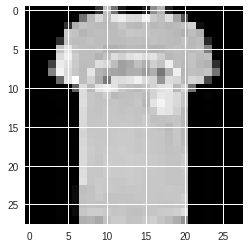

1 Trouser


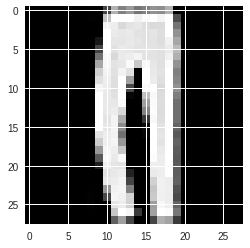

2 Pullover


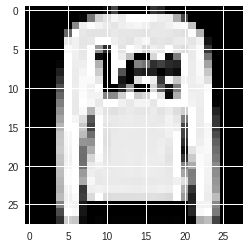

3 Dress


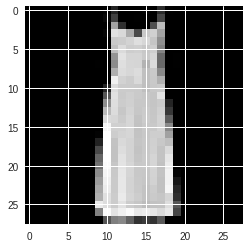

4 Coat


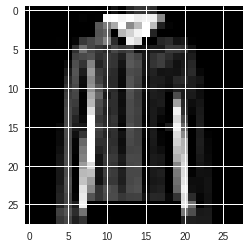

5 Sandal


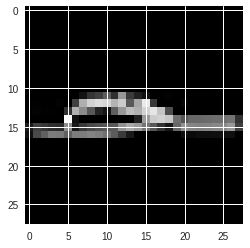

6 Shirt


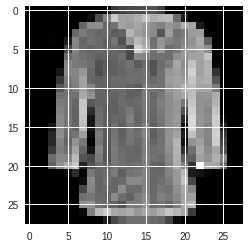

7 Sneaker


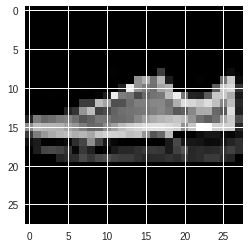

8 Bag


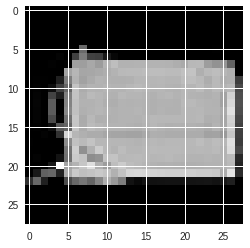

9 Ankle boot


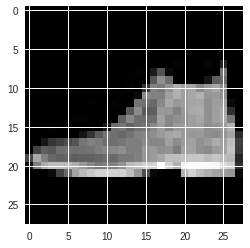

In [17]:
for label_name in LABEL_NAMES:
    this_data = ((x,t) for x, t in test if get_label_name(t) == label_name)  # generator
    x, t = next(this_data)
    print(t, label_name)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()

In [0]:
#trainとvalidationの分割
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

In [24]:
print(len(train),len(validation))

50000 10000


課題
上記の文脈で、下記の言葉がどのような意味か調べて、説明を書いてみましょう。

モデル選択
汎化誤差、汎化性能
過学習
交差検証


In [0]:
#2層パーセプトロン
import chainer.functions as F
import chainer.links as L
from chainer import Chain #chainはパラメータを持つ層をまとめていくクラス

class MLP2(Chain):

    # Initialization of layers
    def __init__(self):
        super(MLP2, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)  # From 784-dimensional input to hidden unit with 200 nodes
            self.l2=L.Linear(200, 10)  # From hidden unit with 200 nodes to output unit with 10 nodes  (10 classes)

    # Forward computation
    def forward(self, x):
        h1 = F.tanh(self.l1(x))  # Forward from x to h1 through activation with tanh function
        y = self.l2(h1)  # Forward from h1to y
        return y

In [35]:
l1 = L.Linear(784,200)
l2 = L.Linear(200,10)
print(l1.W.shape,l2.W.shape)


(200, 784) (10, 200)


In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device):
    
    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()

In [0]:
device = -1  # specify gpu id. if device == -1, use cpu
n_epoch = 5  # Only 5 epochs
batchsize = 256

model = MLP2() # MLP2 model
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

In [38]:
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.43346     0.600546       1.04442        0.67627            1.96388       
2           0.914816    0.70649        0.845244       0.72041            5.02587       
3           0.78301     0.74403        0.756861       0.744629           8.16565       
4           0.712996    0.765725       0.702399       0.762305           11.5515       
5           0.665964    0.781931       0.663619       0.77627            14.7948       


In [0]:
import pydot
from IPython.display import Image, display

def show_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')
    display(Image('graph.png', width=600, height=600))

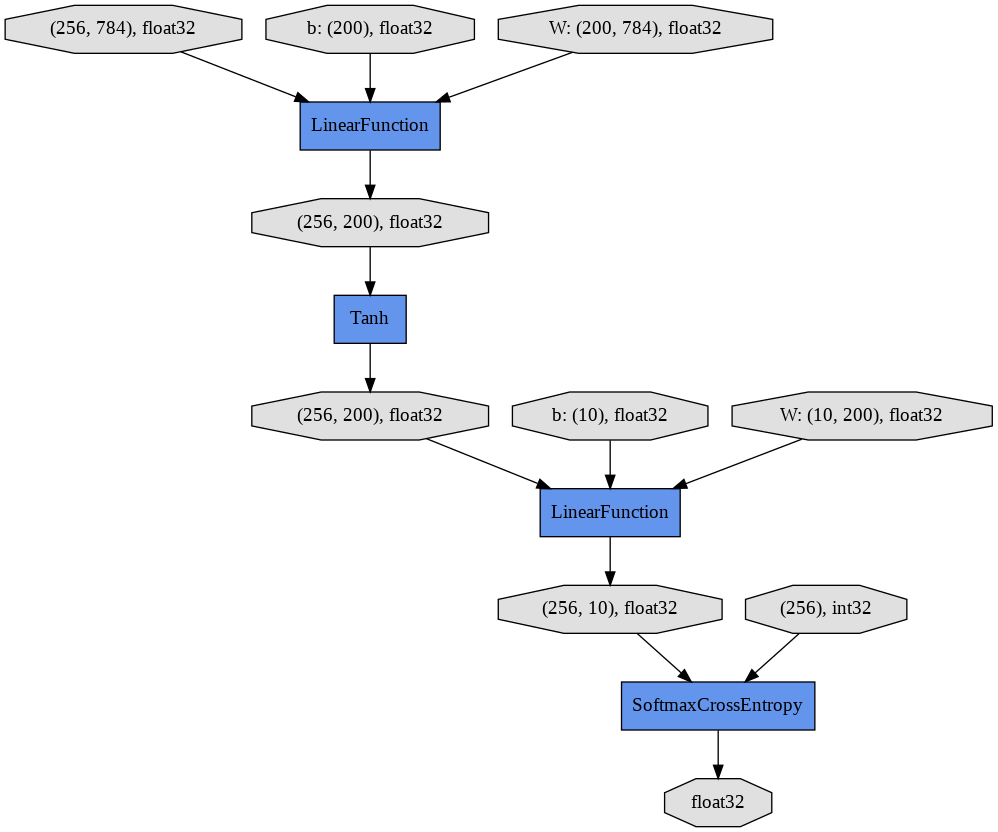

In [40]:
show_graph()

In [0]:
def show_loss_and_accuracy():
    display(Image(filename='out/loss.png'))
    display(Image(filename='out/accuracy.png'))

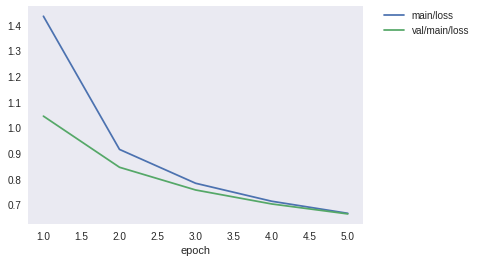

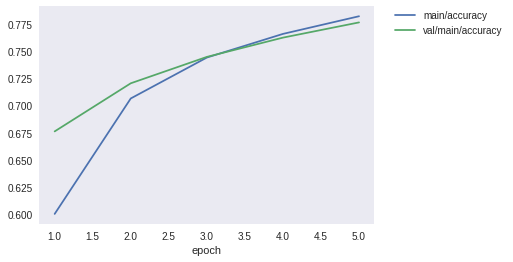

In [42]:
show_loss_and_accuracy()

In [0]:
def show_test_performance(model, test, device, batchsize=256):
    if device >=0:
        model.to_gpu()
    test_iter = chainer.iterators.SerialIterator(
        test, batchsize, repeat=False, shuffle=False
    )
    test_evaluator = extensions.Evaluator(test_iter, model, device=device)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])


In [44]:
show_test_performance(classifier_model, test, device)

Test accuracy: 0.77900390625


In [47]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP2()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.43716     0.607183       1.04349        0.686719           10.7767       
2           0.909782    0.721454       0.835588       0.727051           13.9057       
3           0.774895    0.752624       0.747612       0.749219           17.0115       
4           0.705711    0.770926       0.693763       0.76709            20.3148       
5           0.660735    0.784575       0.657779       0.778906           23.4668       


In [0]:
## 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):

    def __init__(self):
        super(MLP3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 200)   # Additional  layer
            self.l3=L.Linear(200, 10)

    def forward(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

In [49]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP3()  # Use MLP3 instead of MLP2
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.40662     0.606425       1.0099         0.685059           3.06675       
2           0.873199    0.725321       0.800191       0.737012           6.61293       
3           0.73347     0.7624         0.70706        0.760156           10.1519       
4           0.660843    0.782685       0.651849       0.774512           13.7529       
5           0.613933    0.794732       0.615035       0.788281           17.2872       


In [0]:
## Find three bugs in this model definition
class MLP3Wrong(Chain):

    def __init__(self):
        super(MLP3Wrong, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 200)
            self.l3=L.Linear(200, 10)

    def forward(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(h1))
        y = self.l3(h2)
        return y

In [53]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP3Wrong()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.43132     0.583825       1.01411        0.67959            2.84973       
2           0.878934    0.716747       0.805355       0.730078           6.22452       
3           0.739754    0.757472       0.71228        0.761426           9.60567       
4           0.665707    0.780054       0.657185       0.773535           13.0495       
5           0.617555    0.794872       0.617041       0.787891           16.4995       


In [0]:
class MLP4(Chain):

    def __init__(self):
        super(MLP4, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 100)
            self.l3=L.Linear(100, 50)
            self.l4=L.Linear(50,10)

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        y = self.l4(h3)
        return y

In [57]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP4()
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.4141      0.598912       1.03816        0.668945           3.36336       
2           0.900304    0.71246        0.815157       0.730859           7.2036        
3           0.74712     0.754567       0.709584       0.753906           11.0381       
4           0.662459    0.779018       0.644529       0.782715           15.0802       
5           0.607616    0.796494       0.601376       0.793359           18.9045       


In [0]:
## Let's create new Multi-Layer Perceptron (MLP)
class MLPNew(Chain):

    def __init__(self):
        # Add more layers?
        super(MLPNew, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)  # Increase output node as (784, 300)?
            self.l2=L.Linear(200, 100)  # Increase nodes as (300, 300)?
            self.l3=L.Linear(100, 10)      # Increase nodes as (300, 10)?

    def forward(self, x):
        h1 = F.relu(self.l1(x))        # Replace F.tanh with F.sigmoid  or F.relu ?
        h2 = F.sigmoid(self.l2(h1))        # Replace F.tanh with F.sigmoid  or F.relu ?
        y = self.l3(h2)
        return y

In [99]:
import time

start = time.time()
#func()
process_time = time.time() - start

device = 0
n_epoch = 10  # Add more epochs?
batchsize = 128  # Increse/Decrese mini-batch size?

model = MLP4() 
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()  # Use other optimizer, Adam()?

train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

print(process_time)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.578263    0.797395       0.434297       0.845728           6.51593       
2           0.394526    0.858456       0.407548       0.84998            13.5278       
3           0.346195    0.874479       0.35178        0.87144            20.4595       
4           0.324086    0.880695       0.367249       0.865407           27.3852       
5           0.303408    0.888387       0.333996       0.875989           34.5066       
6           0.291809    0.891707       0.334426       0.876681           41.5635       
7           0.275084    0.897618       0.325501       0.88034            48.4934       
8           0.263482    0.901563       0.334423       0.874209           55.4223       
9           0.256023    0.903593       0.343399       0.874407           62.4233       
10          0.245481    0.908288       0.333825       0.880241           69.7758       
2.7418136596679688e-05


In [100]:
show_test_performance(classifier_model, test, device)

Test accuracy: 0.88291013


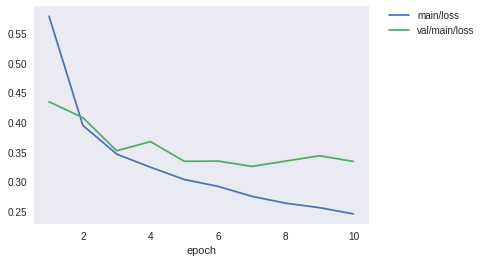

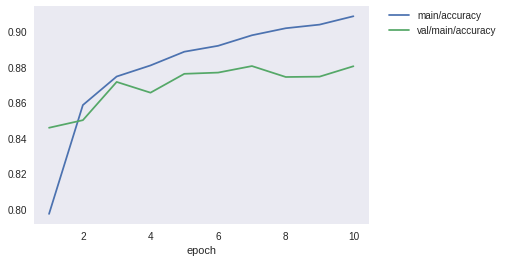

In [101]:
show_loss_and_accuracy()

In [0]:
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1, pad=0)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1, pad=0)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1, pad=0)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def forward(self, x):
        h = F.sigmoid(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        return self.fc5(h)

In [103]:
device = 0
n_epoch = 10
batchsize = 256

model = LeNet5()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.86828     0.34082        1.15666        0.578809           5.54812       
2           0.962657    0.640805       0.870151       0.680664           10.1808       
3           0.783713    0.706891       0.752706       0.716895           14.7843       
4           0.690993    0.735352       0.680316       0.731445           19.6517       
5           0.64238     0.749339       0.646141       0.744336           24.3053       
6           0.609895    0.761799       0.613749       0.757129           28.9633       
7           0.582258    0.773657       0.588049       0.763965           33.6233       
8           0.558788    0.782392       0.57131        0.77334            38.244        
9           0.539019    0.789904       0.576239       0.774219           42.8749       
10          0.520117    0.798788       0.531254       0.789551           47.5266       
